In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py as h5
import healpy as hp
import os
import meander
import csky as cy
import pickle as pkl

In [2]:
import setup

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2019_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2012_data.npy ...
Reading /

In [3]:
mpl.rcParams['font.size'] = 20

In [6]:
timer = cy.timing.Timer()
time = timer.time

In [102]:
dat_loc='/data/user/jthwaites/chime_localization_data/'
dat_files=os.listdir(dat_loc)

In [5]:
#making sample localizations with files from chime cat 1
#f1 = h5.File(dat_loc+'FRB20190416A_localization.h5','r')
#f2 = h5.File(dat_loc+'FRB20180907D_localization.h5','r')
samp_f =[dat_loc+dat_files[i] for i in [2,100,200,300,400]]

In [20]:
#copied directly from https://chime-frb-open-data.github.io/localization.html
# The following function just summarizes the HDF5 file structure:
def describe(group, recurse=False):
    """ Prints info on the contents of an hdf5 group """

    print(group.name)

    # First print header-like attributes (if exist)
    if group.attrs:
        print('\n  attrs: {')
    for key, value in group.attrs.items():
        if key in ['comments', 'history']:
            print('    %s:' % key)
            for line in value:
                print('      ' + str(line))
        else:
            print('    %s:' % key, value)
    if group.attrs:
        print('  }')

    # Then print constituent groups & datasets
    print()
    for key, value in group.items():
        if isinstance(value, h5.Group):
            if recurse:
                print('-'*60)
                describe(value, True)
            else:
                print('  ' + key + '/')
        else:
            print('  ' + key + ':', value.shape, value.dtype)
    print()
#describe(samp_f['/'])

In [104]:
new_localizations={'tns_name':[],'dec':[],'ra':[],
                   'ra_unc_68':[],'dec_unc_68':[],'ra_unc_90':[],'dec_unc_90':[]}
for file in dat_files:
    f = h5.File(dat_loc+file,'r')
    
    ra_loc=f['/'].attrs['ra_error']
    dec_loc=f['/'].attrs['dec_error']

    new_localizations['tns_name'].append(file[0:12])
    new_localizations['dec'].append(f['/'].attrs['dec'])
    new_localizations['ra'].append(f['/'].attrs['ra'])
    
    for cl in [68,90]:
        extent=[[0,361],[0,91]]
        if cl == 68: contours=f['/contours/68/'].items()
        elif cl == 90: contours= f['/contours/90/'].items()
        for name, contour in contours:
            contour=contour[:]
            max_ra=max(contour[0])
            if max_ra> extent[0][0]: extent[0][0]=max_ra
            min_ra=min(contour[0])
            if min_ra< extent[0][1]: extent[0][1]=min_ra
            max_dec=max(contour[1])
            if max_dec> extent[1][0]: extent[1][0]=max_dec
            min_dec=min(contour[1])
            if min_dec < extent[1][1]: extent[1][1]=min_dec
    
        if (extent[0][0]-extent[0][1]) > ra_loc: ra_loc=extent[0][0]-extent[0][1]
        if (extent[1][0]-extent[1][1]) > dec_loc: dec_loc=extent[1][0]-extent[1][1]
        new_localizations['ra_unc_'+str(cl)].append(ra_loc)
        new_localizations['dec_unc_'+str(cl)].append(dec_loc)
        
with open('sp_maps_extent.pkl', 'wb') as outfile:
    pkl.dump(new_localizations, outfile)

Text(0.5,1,'Chime Catalog 1 localization errors')

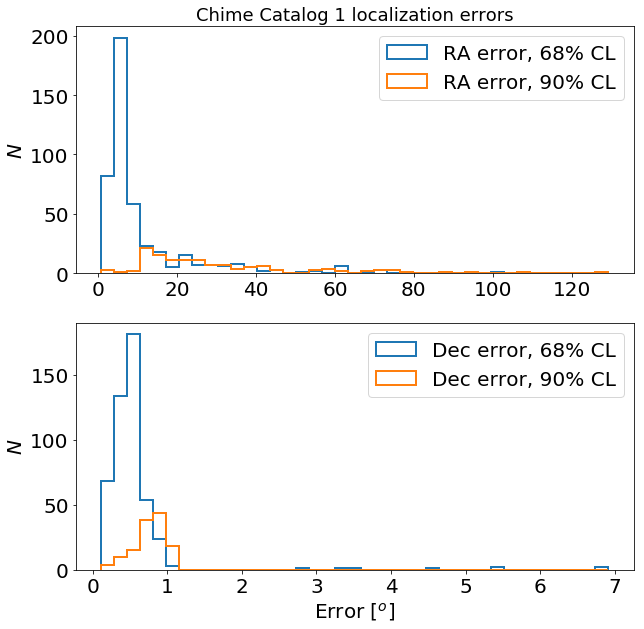

In [6]:
"""Plot new localizations from full 68% contours"""
dec_bins=np.linspace(min(new_localizations['dec_unc_90']),
                     max(new_localizations['dec_unc_90']), 
                     num=40)
ra_bins=np.linspace(min(new_localizations['ra_unc_90']),
                    max(new_localizations['ra_unc_90']),
                    num=40)
w=np.where(np.asarray(new_localizations['dec'])>70.)[0]

fig, ax = plt.subplots(2,figsize=(10,10))
mpl.rcParams['font.size'] = 20
ax[0].hist(new_localizations['ra_unc_68'], bins=ra_bins, histtype='step', 
         lw=2., label='RA error, 68% CL', color='C0')
ax[0].hist([new_localizations['ra_unc_90'][i] for i in w], bins=ra_bins, histtype='step', 
         lw=2., label='RA error, 90% CL', color='C1')
ax[1].hist(new_localizations['dec_unc_68'], bins=dec_bins, histtype='step', 
         lw=2., label='Dec error, 68% CL', color='C0')
ax[1].hist([new_localizations['dec_unc_90'][i] for i in w], bins=dec_bins, histtype='step', 
         lw=2., label='Dec error, 90% CL', color='C1')

ax[0].set_ylabel(r'$N$')
ax[1].set_ylabel(r'$N$')
ax[1].set_xlabel(r'Error [$^o$]')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[0].set_title(r'Chime Catalog 1 localization errors', fontsize=18)
#plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_loc_err_new.png')

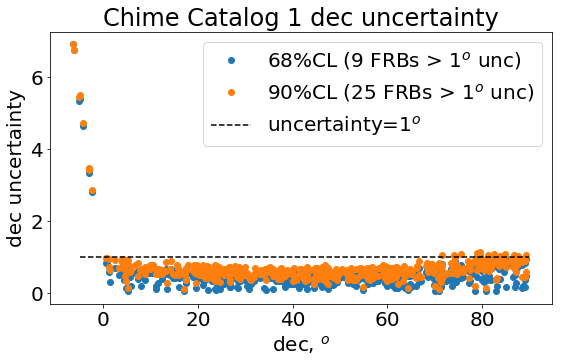

In [12]:
fig, ax = plt.subplots(figsize=(9,5))
w_unc_68=np.where(np.asarray(new_localizations['dec_unc_68'])>1.)[0]
w_unc_90=np.where(np.asarray(new_localizations['dec_unc_90'])>1.)[0]

plt.plot(new_localizations['dec'], new_localizations['dec_unc_68'], 
         'o', label='68%CL ('+str(len(w_unc_68))+r' FRBs > 1$^o$ unc)', color='C0')
plt.plot(new_localizations['dec'], new_localizations['dec_unc_90'], 
         'o', label='90%CL ('+str(len(w_unc_90))+r' FRBs > 1$^o$ unc)', color='C1')
ax.set_ylabel(r'dec uncertainty')
ax.set_xlabel(r'dec, $^o$')
ax.set_title(r'Chime Catalog 1 dec uncertainty')
plt.plot(np.linspace(-5,90,50), np.ones(50), '--',color='black', label=r'uncertainty=1$^o$')
plt.legend()

#w_unc=np.where(np.asarray(new_localizations['dec_unc_90'])>1.)[0]
#high_unc=[[new_localizations['dec'][u] for u in w_unc],
#          [new_localizations['dec_unc_90'][u] for u in w_unc]]
#plt.plot(np.sin(np.radians(high_unc[0])), high_unc[1], 'o', label=r'uncertainty > 1$^o$',
#        color='C1')
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_decunc.png')

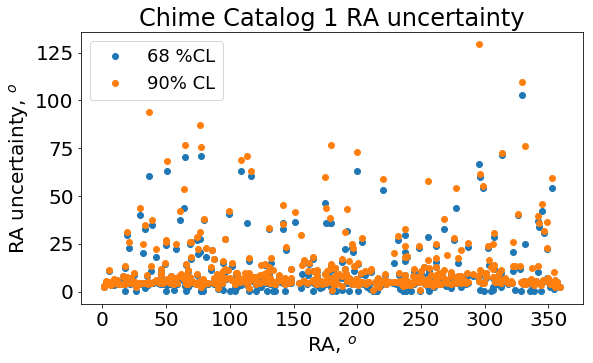

In [9]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(new_localizations['ra'], new_localizations['ra_unc_68'], 
         'o', label='68 %CL', color='C0')
plt.plot(new_localizations['ra'], new_localizations['ra_unc_90'], 
         'o', label='90% CL', color='C1')
ax.set_ylabel(r'RA uncertainty, $^o$')
ax.set_xlabel(r'RA, $^o$')
ax.set_title(r'Chime Catalog 1 RA uncertainty')

plt.legend(fontsize=18)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_raunc2.png')

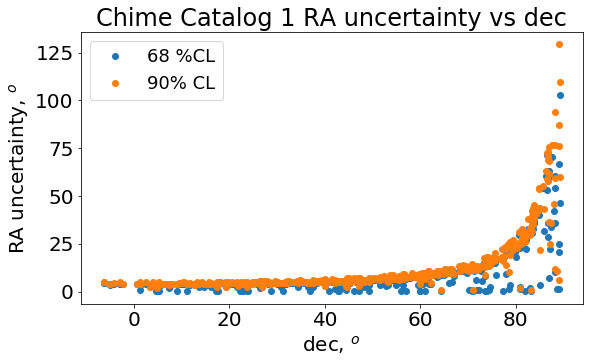

In [9]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(new_localizations['dec'], new_localizations['ra_unc_68'], 
         'o', label='68 %CL', color='C0')
plt.plot(new_localizations['dec'], new_localizations['ra_unc_90'], 
         'o', label='90% CL', color='C1')
ax.set_ylabel(r'RA uncertainty, $^o$')
ax.set_xlabel(r'dec, $^o$')
ax.set_title(r'Chime Catalog 1 RA uncertainty vs dec')

##looks like a 1/cos fit mult by det syst - show this
dec=np.arange(min(new_localizations['dec']), 88.5)
w=np.where(new_localizations['dec']==min(new_localizations['dec']))[0]
fit=new_localizations['ra_unc_90'][w[0]]*(1/(np.cos(np.radians(dec))))
#plt.plot(dec, fit, color='C2',label='A*1/cos(dec)')

plt.legend(fontsize=18)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_raunc_v_dec.png')

In [16]:
new_localizations['d_openangle_68']=[]
new_localizations['d_openangle_90']=[]
for j in range(len(new_localizations['ra'])):
    d_oa_68=hp.rotator.angdist([new_localizations['ra'][j]-new_localizations['ra_unc_68'][j]/2,
                               new_localizations['dec'][j]-new_localizations['dec_unc_68'][j]/2],
                               [new_localizations['ra'][j]+new_localizations['ra_unc_68'][j]/2,
                               new_localizations['dec'][j]+new_localizations['dec_unc_68'][j]/2],
                               lonlat=True)
    d_oa_90=hp.rotator.angdist([new_localizations['ra'][j]-new_localizations['ra_unc_90'][j]/2,
                               new_localizations['dec'][j]-new_localizations['dec_unc_90'][j]/2],
                               [new_localizations['ra'][j]+new_localizations['ra_unc_90'][j]/2,
                               new_localizations['dec'][j]+new_localizations['dec_unc_90'][j]/2],
                               lonlat=True)   
    new_localizations['d_openangle_68'].append(np.degrees(d_oa_68[0]))
    new_localizations['d_openangle_90'].append(np.degrees(d_oa_90[0]))

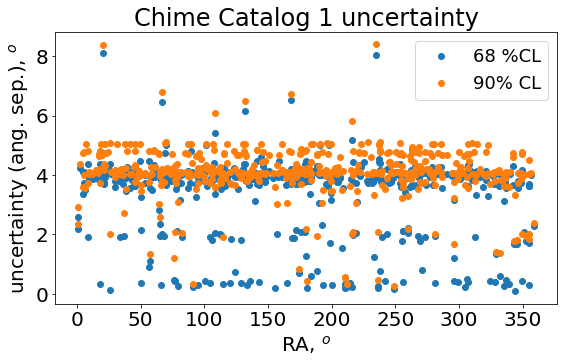

In [11]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(new_localizations['ra'], new_localizations['d_openangle_68'], 
         'o', label='68 %CL', color='C0')
plt.plot(new_localizations['ra'], new_localizations['d_openangle_90'], 
         'o', label='90% CL', color='C1')
ax.set_ylabel(r'uncertainty (ang. sep.), $^o$')
ax.set_xlabel(r'RA, $^o$')
ax.set_title(r'Chime Catalog 1 uncertainty')

plt.legend(fontsize=18)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_oaunc2.png')

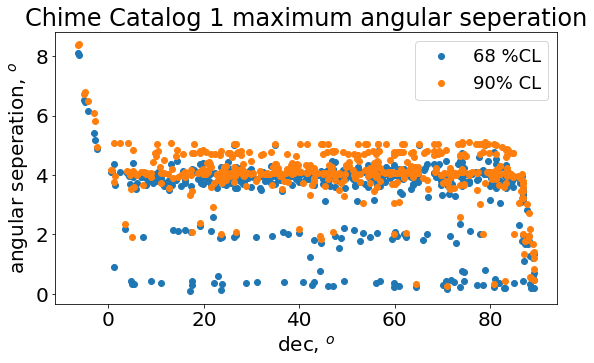

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(new_localizations['dec'], new_localizations['d_openangle_68'], 
         'o', label='68 %CL', color='C0')
plt.plot(new_localizations['dec'], new_localizations['d_openangle_90'], 
         'o', label='90% CL', color='C1')
ax.set_ylabel(r'angular seperation, $^o$')
ax.set_xlabel(r'dec, $^o$')
ax.set_title(r'Chime Catalog 1 maximum angular seperation')

plt.legend(fontsize=18)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_raunc_v_dec.png')

In [ ]:
"""plot of area (steradians) for each map 68%CL
This cell takes a very long time to evaluate
"""
def calc_area(new_nside=False, max_cl_level=0.68):
    area=[]
    i=0
    for file in dat_files:
        f = h5.File(dat_loc+file, 'r')

        nside = f['healpix'].attrs['nside']
        area_per_pix=12*nside**2
        
        ipix, CL = f['healpix/ipix'][()], f['healpix/CL'][()]
        new_CL = np.ones(hp.nside2npix(nside))
        new_CL[ipix] = CL
        
        if new_nside!=False: 
            new_CL = hp.ud_grade(new_CL, new_nside, order_in='NESTED', order_out='RING')
        #else: new_CL = hp.ud_grade(new_CL, nside, order_in='NESTED', order_out='RING')
        npixels=np.where(CL < max_cl_level)[0]

        ster=4*np.pi/area_per_pix*len(npixels)
        area.append(ster)
        i+=1
        
        if i%40==0: print('%i / %i complete'%(i, len(dat_files)))
        #show_contours(f)
    return area
area_68=calc_area()
print('here')
area_90=calc_area(max_cl_level=0.90)

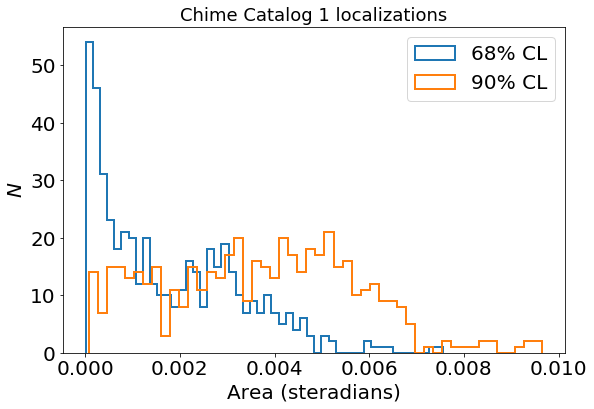

In [53]:
fig, ax = plt.subplots(figsize=(9,6))
mpl.rcParams['font.size'] = 20

ax.hist(area_68, bins=50, histtype='step', lw=2., 
           label='68% CL', color='C0')
ax.hist(area_90, bins=50, histtype='step', lw=2., 
           label='90% CL', color='C1')
ax.set_ylabel(r'$N$')
ax.set_xlabel(r'Area (steradians)')
ax.legend(loc=0)
ax.set_title(r'Chime Catalog 1 localizations', fontsize=18)
plt.savefig('/home/jthwaites/public_html/frb_param_plots/cat1_areaunc.png')

In [13]:
def show_contours(f):
    fig, ax = plt.subplots(figsize=(10,2.5))
    i=0
    for name, contour in f['/contours/68/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C0', label='68% CL')
        else: plt.plot(contour[0],contour[1],color='C0')
        i+=1
    i=0
    for name, contour in f['/contours/90/'].items():
        contour=contour[:]
        if i==0: plt.plot(contour[0],contour[1],color='C1', label='90% CL')
        else: plt.plot(contour[0],contour[1],color='C1')
        i+=1
    ax.invert_xaxis()
    plt.xlabel('R.A. (deg)')
    plt.ylabel('Dec. (deg)')
    plt.legend(loc=4)
    plt.title('%s Contours'%f['/'].attrs['tns_name'])
    plt.show()

In [49]:
#recreate chime cat 1 localization plots from paper
def show_localizations(f2):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots( figsize=(10,4))

    # Note: RA increases to the left!
    hdr = f2['projection'].attrs
    CL = f2['projection/data'][:]
    extent = np.array([-hdr['xsize']/2, hdr['xsize']/2, 
                -hdr['ysize']/2, hdr['ysize']/2])*hdr['reso']/60

    im = ax.imshow(CL, vmin=0, origin='lower',
                extent=extent, cmap='magma')
    ax.contour(CL, levels=[0.68, 0.95], linestyles=['-', '--'], 
                colors='k', linewidths=2, extent=extent)
    ax.set_title('%s \n RA= %.2f$\pm$%.2f$^o$, dec= %.2f$\pm$%.2f$^o$' 
                %(f2.attrs['tns_name'],hdr['clon'], 
                    f2.attrs['ra_error'], hdr['clat'], f2.attrs['dec_error']))
    ax.set_xlabel('$\Delta$RA (deg)')
    ax.set_ylabel('$\Delta$dec (deg)')

    plt.colorbar(im, pad=0.25, shrink=0.4, orientation='horizontal',
                label='Confidence Level')
    plt.show()
    #plt.savefig('./frb_param_plots/sample1_locpdfs.png')

In [19]:
# https://github.com/icecube/FastResponseAnalysis/blob/1ef71ea017805e7180f2b616796ba5474284aa88/fast_response/FastResponseAnalysis.py#L1218
# Other functions here have things that add axis labels and such

def plot_zoom(scan, ra, dec, levels=[0.90], title='', reso=3, 
              var="pVal", range=[0, 6],cmap='Blues', contour_scan=None, CL=None):
    if cmap is None:
        pdf_palette = sns.color_palette("Blues", 500)
        cmap = mpl.colors.ListedColormap(pdf_palette)
    hp.gnomview(scan, rot=(np.degrees(ra), np.degrees(dec), 0),
                    cmap=cmap,
                    max=max(scan),
                    reso=reso,
                    title=title,
                    notext=True,
                    cbar=False,
                    nest=False
                    #unit=r""
                    )
    levels=[0.68,0.90] # 68%,90% containment 
    
    if CL is not None:
        theta, phi = plot_contours_with_mask(CL, levels)
    elif contour_scan is None:
        theta, phi = plot_contours(levels,scan)
    else:
        theta, phi = plot_contours(levels,contour_scan)
    
    hp.projplot(theta[0],phi[0],linewidth=1,c='k',label='%i%% C.L'%(levels[0]*100))
    for i in np.arange(1,len(theta)): 
        hp.projplot(theta[i],phi[i],c='k',linewidth=1)
        
    plt.plot(4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 
             4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), color="k", ls="-", lw=3)

    draw_axes(dec, ra, reso)
    plot_color_bar(cmap='Blues', labels=[0.,np.around(max(scan),decimals=3)])
    #hp.graticule(verbose=False)

def draw_axes(src_dec, src_ra, reso, axis_labels=True):
    plt.plot(
        4.95/3.*reso*np.radians([-1, 1, 1, -1, -1]), 
        4.95/3.*reso*np.radians([1, 1, -1, -1, 1]), 
        color="k", ls="-", lw=3
        )
    ra_scale_factor = 3 if np.degrees(np.abs(src_dec)) < 30. else 10
    num_ra_lines = ra_scale_factor*reso
    num_dec_lines = 3*reso
    ra_axes = np.linspace(
        np.degrees(src_ra)-360.,
        np.degrees(src_ra)+360.,
        721
        )
    ra_axes = ra_axes[
        (ra_axes > (np.degrees(src_ra) - num_ra_lines)) & \
        (ra_axes < (np.degrees(src_ra) + num_ra_lines))
        ]
    ra_axes = np.where(ra_axes > 360., ra_axes - 360., ra_axes)
    dec_axes = np.linspace(
        np.degrees(src_dec) - 180.,
        np.degrees(src_dec) + 180.,
        361.
        )
    dec_axes = dec_axes[
        (dec_axes > (np.degrees(src_dec) - num_dec_lines)) & \
        (dec_axes < (np.degrees(src_dec) + num_dec_lines))
        ]
    dec_axes = dec_axes[(dec_axes > -90.) & (dec_axes < 90.)]
    for tmp_ra in ra_axes:
        tmp_line_ra = np.radians(np.ones(500)*tmp_ra)
        tmp_line_dec = np.radians(np.linspace(dec_axes[0], dec_axes[-1], 500))
        hp.projplot(np.pi/2. - tmp_line_dec, tmp_line_ra, linewidth=0.5, 
                    color='k', linestyle='dotted', coord='C')
    for tmp_dec in dec_axes:
        tmp_line_dec = np.radians(np.ones(500)*tmp_dec)
        tmp_line_ra = np.radians(np.linspace(ra_axes[0], ra_axes[-1], 500))
        hp.projplot(np.pi/2. - tmp_line_dec, tmp_line_ra, linewidth=0.5, 
                    color='k', linestyle='dotted', coord='C')
    plot_labels(src_dec, src_ra, reso, with_axis_labels=axis_labels)    

def plot_color_bar(labels=[0.,2.,4.,6.], col_label=r"Probability", range=[0,6], cmap=None, offset=-35):
    fig = plt.gcf()
    #ax = fig.add_axes([0.25, -0.03, 0.5, 0.03])
    ax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
    cb = mpl.colorbar.ColorbarBase(ax, cmap=ps_map if cmap is None else cmap,
                        #norm=mpl.colors.Normalize(vmin=range[0], vmax=range[1]), 
                        orientation="vertical")
    #cb.ax.minorticks_on()
    cb.set_label(col_label,labelpad=offset, fontsize=18)
    cb.set_ticks([0., 1.])
    cb.set_ticklabels(labels)
    cb.update_ticks()
    #cb.ax.get_xaxis().set_ticklabels(labels)

def plot_labels(src_dec, src_ra, reso, with_axis_labels=True):
    """Add labels to healpy zoom"""
    fontsize = 20
    
    if np.degrees(src_dec) > 35.:
        ras = [
            np.degrees(src_ra) - reso*3,
            np.degrees(src_ra),
            np.degrees(src_ra) + reso*3
            ]
    else:
        ras = [
            np.degrees(src_ra) - reso,
            np.degrees(src_ra),
            np.degrees(src_ra) + reso
            ]
    decs = [
        np.degrees(src_dec) - reso,
        np.degrees(src_dec),
        np.degrees(src_dec) + reso
        ]
    for ra in ras:
        dec_text = np.pi/2. - src_dec + (np.radians(reso) * 5.5/3.)
        dec_offset = np.abs(np.radians(ra - np.degrees(src_ra)))*np.sin(src_dec)*reso*0.01
        ra_text = "{:.2f}$^\circ$".format(ra) if ra < 360. else "{:.2f}$^\circ$".format(ra - 360.)
        hp.projtext(dec_text + dec_offset, np.radians(ra),
                    ra_text, lonlat=False,
                    fontsize=20, ha='center')
    for dec in decs:
        scale = np.degrees(hp.rotator.angdist(
            [np.pi/2. - np.radians(dec), src_ra], 
            [np.pi/2. - np.radians(dec), src_ra + np.radians(1.)]
            ))
        ra_text = np.radians(np.degrees(src_ra) + 1.7*reso/scale)
        hp.projtext(np.pi/2. - np.radians(dec), ra_text,
            "{:.2f}$^\circ$".format(dec), lonlat=False,
            fontsize=20, ha='right')
    
    if with_axis_labels:
        plt.text(-1.05*np.radians(2.4*reso), np.radians(0), r"declination",
                    ha='center', va='center', rotation=90, fontsize=fontsize)
        plt.text(np.radians(0), np.radians(-2*reso), r"right ascension",
                    ha='center', va='center', fontsize=fontsize)

In [20]:
#from Raamis: code to draw contours w Meander
def plot_contours(proportions,samples):
    r''' Plot containment contour around desired level.
    E.g 90% containment of a PDF on a healpix map    
    Parameters:
    -----------
    proportions: list
        list of containment level to make contours for.
        E.g [0.68,0.9]
    samples: array
        array of values read in from healpix map
        E.g samples = hp.read_map(file)
    Returns:
    --------
    theta_list: list
        List of arrays containing theta values for desired contours
    phi_list: list
        List of arrays containing phi values for desired contours
    '''    
    levels = []
    sorted_samples = list(reversed(list(sorted(samples))))
    
    nside = hp.pixelfunc.get_nside(samples)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(samples)))).T
    
    for proportion in proportions:
        level_index = (np.cumsum(sorted_samples) > proportion).tolist().index(True)
        level = (sorted_samples[level_index] + (sorted_samples[level_index+1] 
                                        if level_index+1 < len(samples) else 0)) / 2.0
        levels.append(level)
    contours_by_level = meander.spherical_contours(sample_points, samples, levels)    
    
    theta_list = []; phi_list=[]
    for contours in contours_by_level:
        for contour in contours:
            theta, phi = contour.T
            phi[phi<0] += 2.0*np.pi
            theta_list.append(theta)
            phi_list.append(phi)    
    return theta_list, phi_list

def plot_contours_with_mask(CL, CL_levels):
    ''' Plot containment contour around desired level.
    theta_list: List of arrays containing theta values for desired contours
    phi_list: List of arrays containing phi values for desired contours'''
    
    nside = hp.pixelfunc.get_nside(CL)
    sample_points = np.array(hp.pix2ang(nside,np.arange(len(CL)))).T
    
    max_cl_level = 0.99999
    msk = CL < max_cl_level
    
    contours_by_level = meander.spherical_contours(sample_points[msk], CL[msk], CL_levels)
    
    theta_list = []; phi_list=[]
    for contours in contours_by_level:
        for contour in contours:
            theta, phi = contour.T
            phi[phi<0] += 2.0*np.pi
            theta_list.append(theta)
            phi_list.append(phi)    
    return theta_list, phi_list

In [21]:
tns_name='FRB20190517C'
index=np.where(tns_name==np.asarray(new_localizations['tns_name']))[0][0]
frb = dat_loc + tns_name+'_localization.h5'
f = h5.File(frb, 'r')

def make_healpix_mapping(f, reso=2., new_nside=512, use_msk=True, title=''):
    ra = np.radians(f['/'].attrs['ra'])
    dec = np.radians(f['/'].attrs['dec'])

    original_nside = f['healpix'].attrs['nside']
    ipix, CL = f['healpix/ipix'][()], f['healpix/CL'][()]
    #for some reason, it appears there are duplicates of these in all the files. 
    #To remove, use np.unique fxn
    unique_CLs, CL_ind=np.unique(ipix, return_index=True)

    probs = (1. - CL)/ (1. - CL[CL_ind]).sum()
    frb_probs = np.zeros(hp.nside2npix(original_nside))
    frb_probs[ipix] = probs
    new_CL = np.ones_like(frb_probs)
    new_CL[ipix] = CL
    
    frb_probs = hp.ud_grade(frb_probs,
                new_nside, order_in='NESTED', order_out='RING', power=-2)
    new_CL = hp.ud_grade(new_CL,
                new_nside, order_in='NESTED', order_out='RING')
    
    print('Total map probability = %.6f'%frb_probs.sum())
    if use_msk==True: 
        plot_zoom(frb_probs, ra, dec, reso=reso, CL=new_CL, title=title)
    else: 
        plot_zoom(frb_probs, ra, dec, reso=reso/2, title=title)

#make_healpix_mapping(f, new_nside=256)

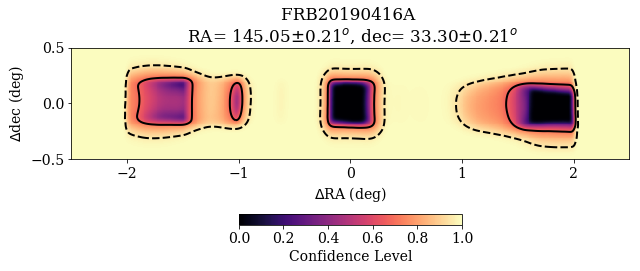

Total map probability = 1.000000


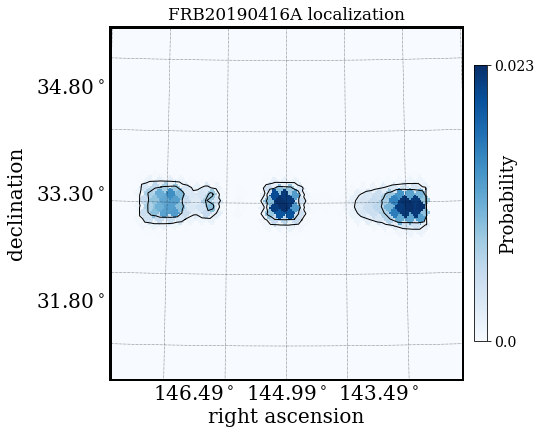

In [34]:
f2 = h5.File(dat_loc+'FRB20190416A_localization.h5','r')
show_localizations(f2)
#show_contours(f2)
#with(time('healpix map, %s, nside=512'%samp_f[0][len(dat_loc):])):
#    make_healpix_mapping(f2, new_nside=512)
make_healpix_mapping(f2, reso=1.5, title='FRB20190416A localization')

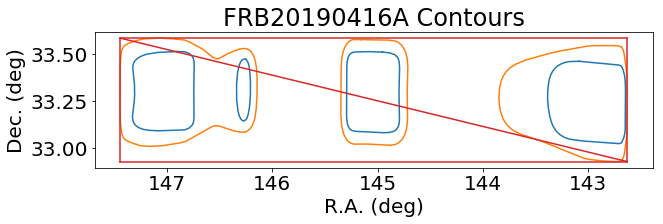

In [51]:
f = h5.File(dat_loc+'FRB20190416A_localization.h5','r')
#show_contours(f2)

fig, ax = plt.subplots(figsize=(10,2.5))
i=0
extent=[[0,361],[0,91]]
for name, contour in f['/contours/68/'].items():
    contour=contour[:]
    max_ra=max(contour[0])
    if max_ra> extent[0][0]: extent[0][0]=max_ra
    min_ra=min(contour[0])
    if min_ra< extent[0][1]: extent[0][1]=min_ra
    max_dec=max(contour[1])
    if max_dec> extent[1][0]: extent[1][0]=max_dec
    min_dec=min(contour[1])
    if min_dec < extent[1][1]: extent[1][1]=min_dec
        
    if i==0: plt.plot(contour[0],contour[1],color='C0', label='68% CL')
    else: plt.plot(contour[0],contour[1],color='C0')
    i+=1
ras=np.linspace(extent[0][1],extent[0][0],100)
decs=np.linspace(extent[1][1],extent[1][0],100)
#plt.plot(ras,extent[1][1]*np.ones_like(ras),color='C0')
#plt.plot(ras,extent[1][0]*np.ones_like(ras),color='C0')
#plt.plot(extent[0][1]*np.ones_like(ras),decs,color='C0')
#plt.plot(extent[0][0]*np.ones_like(ras),decs,color='C0')
#plt.plot(ras,decs,color='C4')

i=0
extent=[[0,361],[0,91]]
for name, contour in f['/contours/90/'].items():
    contour=contour[:]
    max_ra=max(contour[0])
    if max_ra> extent[0][0]: extent[0][0]=max_ra
    min_ra=min(contour[0])
    if min_ra< extent[0][1]: extent[0][1]=min_ra
    max_dec=max(contour[1])
    if max_dec> extent[1][0]: extent[1][0]=max_dec
    min_dec=min(contour[1])
    if min_dec < extent[1][1]: extent[1][1]=min_dec
    
    if i==0: plt.plot(contour[0],contour[1],color='C1', label='90% CL')
    else: plt.plot(contour[0],contour[1],color='C1')
    i+=1
ras=np.linspace(extent[0][1],extent[0][0],100)
decs=np.linspace(extent[1][1],extent[1][0],100)
plt.plot(ras,extent[1][1]*np.ones_like(ras),color='C3')
plt.plot(ras,extent[1][0]*np.ones_like(ras),color='C3')
plt.plot(extent[0][1]*np.ones_like(ras),decs,color='C3')
plt.plot(extent[0][0]*np.ones_like(ras),decs,color='C3')
plt.plot(ras,decs,color='C3')
    
ax.invert_xaxis()
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
#plt.legend(loc=4)
plt.title('%s Contours'%f['/'].attrs['tns_name'])
plt.show()

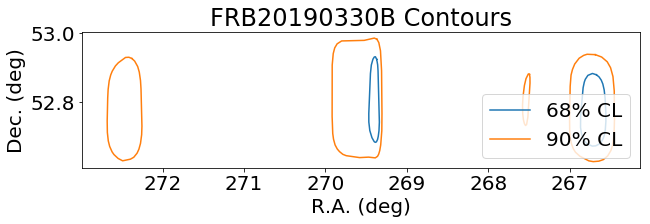

Total map probability = 1.000000

0:00:10.833924 elapsed.
Total map probability = 1.000000

0:00:16.606362 elapsed.


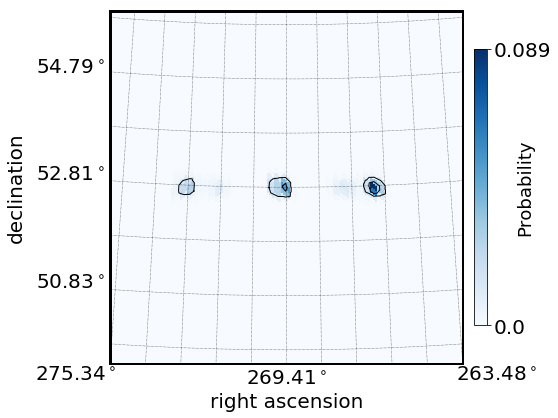

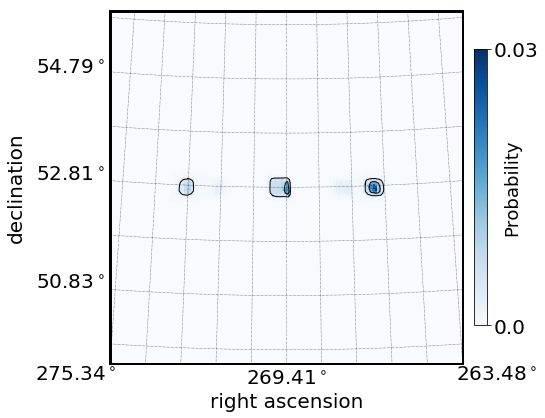

In [18]:
f2=h5.File(samp_f[2],'r')
#show_localizations(f2)
show_contours(f2)
with(time('healpix map, %s, nside=512'%samp_f[2][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=512)
with(time('healpix map, %s, nside=1024'%samp_f[2][len(dat_loc):])):
    make_healpix_mapping(f2, new_nside=1024)

In [19]:
print(timer)

healpix map, FRB20180906B_localization.h5, nside=512  | 0:00:11.150736
healpix map, FRB20180906B_localization.h5, nside=1024 | 0:00:16.988051
healpix map, FRB20190103E_localization.h5, nside=512  | 0:00:11.253869
healpix map, FRB20190103E_localization.h5, nside=1024 | 0:00:17.504498
healpix map, FRB20190330B_localization.h5, nside=512  | 0:00:10.833924
healpix map, FRB20190330B_localization.h5, nside=1024 | 0:00:16.606362
----------------------------------------------------------------------
total                                                 | 0:01:24.337440


In [4]:
import catalogs_to_csv as cat
cat.get_catalogs()
import pandas as pd

In [5]:
"""Check for overlap in maps at different time windows
use mask for CL > max_cl """

dat_loc='/data/user/jthwaites/chime_localization_data/'
dat_files=sorted(os.listdir(dat_loc))

import chime_localizations as loc
frbs=setup.load_frbs()
sp_frbs=frbs[frbs['catalog']=='CHIME_1']

names=[d[0:12] for d in dat_files]

w=[]
for src in sp_frbs['src']:
    if src not in names:
        #if src not in ['FRB20190213A', 'FRB20181017A', 'FRB20190116B']:
        [w.append(k) for k in np.where(sp_frbs['src']==src)[0]]

w=np.unique(w)
w=sp_frbs.index[w]
print('total CHIME FRBs: ',len(sp_frbs['src']))
sp_frbs=sp_frbs.drop(w)

Loading all FRBs from catalogs
total CHIME FRBs:  534


In [6]:
print('FRBs with spatial prior: ',len(sp_frbs))
n_repbursts=sp_frbs.index[np.where(sp_frbs['repeater']==True)[0]].values

n_unique_frbs=len(np.unique(sp_frbs['src'][n_repbursts].values))
print('number of repeater bursts w spatial prior: ',len(np.where(sp_frbs['repeater']==True)[0]))
print('number of repeaters: ',n_unique_frbs)
print('individual FRBs: ',(len(sp_frbs)-(41-16)))
print('loc files: ',len(dat_files))

FRBs with spatial prior:  512
number of repeater bursts w spatial prior:  41
number of repeaters:  16
individual FRBs:  487
loc files:  487


In [12]:
def temporal_overlap(tw):
    tw=tw/86400.
    t_overlap=[]
    for i in range(len(dat_files)):
        frb_name=dat_files[i][0:12]
        f=np.where(sp_frbs['src']==frb_name)[0][0]
    
        frb_time=frbs['mjd'].values[f]
        trange=[frb_time-(tw/2.),frb_time+(tw/2.)]
    
        for j in [x for x in range(len(dat_files)) if x != i]:
            frb_name2= dat_files[j][0:12]
            if frb_name == frb_name2: continue
                
            f2=np.where(sp_frbs['src']==frb_name2)[0]
        
            frb_time2=frbs['mjd'].values[f2]
            
            for k in range(len(frb_time2)):
                trange2=[frb_time2[k]-(tw/2.),frb_time2[k]+(tw/2.)]
        
                check1= trange[0]<trange2[0] and trange[1]>trange2[0]
                check2= trange[0]<trange2[1] and trange[1]>trange2[1]
                if check1 or check2: 
                    if [frb_name2,frb_name] not in t_overlap:
                        t_overlap.append([frb_name, frb_name2])
    return t_overlap
        
def spatial_overlap(names, new_nside, max_cl):
    #names= pairs of overlapping names to check
    new_localizations = pd.read_pickle(r'/home/jthwaites/FRB/sp_maps_extent.pkl')
    
    #start by checking if 90%CLs are within 1 degree from extent of CLs - 
    #faster than reading in healpix maps
    s_overlap=[]

    for i in range(len(names)):
        index1= np.where(np.asarray(new_localizations['tns_name'])==names[i][0])[0][0]
        index2= np.where(np.asarray(new_localizations['tns_name'])==names[i][1])[0][0]
    
        ra_max1=new_localizations['ra'][index1]+(new_localizations['ra_unc_90'][index1]/2)+1
        ra_min1=new_localizations['ra'][index1]-(new_localizations['ra_unc_90'][index1]/2)-1
        ra_max2=new_localizations['ra'][index2]+(new_localizations['ra_unc_90'][index2]/2)+1
        ra_min2=new_localizations['ra'][index2]-(new_localizations['ra_unc_90'][index2]/2)-1
    
        if ra_min1>ra_max2 or ra_max1<ra_min2: continue
    
        dec_max1=new_localizations['dec'][index1]+(new_localizations['dec_unc_90'][index1]/2)+1
        dec_min1=new_localizations['dec'][index1]-(new_localizations['dec_unc_90'][index1]/2)-1
        dec_max2=new_localizations['dec'][index2]+(new_localizations['dec_unc_90'][index2]/2)+1
        dec_min2=new_localizations['dec'][index2]-(new_localizations['dec_unc_90'][index2]/2)-1
    
        if dec_min1>dec_max2 or dec_max1<dec_min2: continue
        #print(names[i])
        #print('ra: [%.2f, %.2f] ; [%.2f, %.2f]'%(ra_max1,ra_min1, ra_max2,ra_min2))
        #print('dec: [%.2f, %.2f] ; [%.2f, %.2f]'%(dec_max1,dec_min1, dec_max2,dec_min2))
        
        #if they have some contour overlap +/- 1 degree of contour - make healpix map
        #print('Making contour maps for %s and %s'%(names[i][0],names[i][1]))
        frb_probs, msk1=loc.make_healpix_map(names[i][0], new_nside=new_nside, max_cl=0.9997)
        frb_probs, msk2=loc.make_healpix_map(names[i][1], new_nside=new_nside, max_cl=0.9997)
        loc1=np.where(msk1)[0]
        loc2=np.where(msk2)[0]
        
        p=0
        for pixel in loc2:
            if pixel in loc1: p+=1
        
        if p==0: continue
        print('FRBs: %s and %s'%(names[i][0],names[i][1]))
        print('Number of overlapping pixels: ',p)
        s_overlap.append(names[i])
        
    return s_overlap

"""Function to check both temporal and spatial overlap
    repeated to create overlap vs time window plot
    to check for overlap in sp at all tw"""

def check_overlap(tw=1000., new_nside=256, max_cl=0.9997):
    t_overlap=temporal_overlap(tw)
    if t_overlap==[]: return 
    
    s_overlap=spatial_overlap(t_overlap, new_nside, max_cl)
    if s_overlap==[]: print('No overlap for tw %is found'%tw)
    return s_overlap

In [13]:
#redo 10^7 tw? something failed partway thru
overlap_tw={}
for tw in np.logspace(4,7, num=10):
    print('Time window= %.f'%tw)
    overlap=check_overlap(tw=tw)
    overlap_tw[tw]=overlap

Time window= 10000
No overlap for tw 10000s found
Time window= 21544
No overlap for tw 21544s found
Time window= 46416
No overlap for tw 46415s found
Time window= 100000
FRBs: FRB20190408A and FRB20190409C
Number of overlapping pixels:  23
Time window= 215443
FRBs: FRB20180906B and FRB20181222D
Number of overlapping pixels:  52
FRBs: FRB20190124B and FRB20190124C
Number of overlapping pixels:  12
FRBs: FRB20190408A and FRB20190409C
Number of overlapping pixels:  23
FRBs: FRB20190630C and FRB20190701C
Number of overlapping pixels:  3
Time window= 464159
FRBs: FRB20180814B and FRB20190220A
Number of overlapping pixels:  98
FRBs: FRB20180906B and FRB20181222D
Number of overlapping pixels:  52
FRBs: FRB20181227A and FRB20181230B
Number of overlapping pixels:  2
FRBs: FRB20190124B and FRB20190124C
Number of overlapping pixels:  12
FRBs: FRB20190408A and FRB20190409C
Number of overlapping pixels:  23
FRBs: FRB20190519H and FRB20190519J
Number of overlapping pixels:  13
FRBs: FRB20190609B and

FRBs: FRB20190301B and FRB20190329A
Number of overlapping pixels:  43
FRBs: FRB20190303D and FRB20190415A
Number of overlapping pixels:  41
FRBs: FRB20190304A and FRB20190322B
Number of overlapping pixels:  1
FRBs: FRB20190309A and FRB20190329C
Number of overlapping pixels:  12
FRBs: FRB20190316A and FRB20190411C
Number of overlapping pixels:  10
FRBs: FRB20190320C and FRB20190425A
Number of overlapping pixels:  3
FRBs: FRB20190325A and FRB20190502C
Number of overlapping pixels:  18
FRBs: FRB20190328A and FRB20190426A
Number of overlapping pixels:  23
FRBs: FRB20190328A and FRB20190604G
Number of overlapping pixels:  32
FRBs: FRB20190328B and FRB20190403E
Number of overlapping pixels:  32
FRBs: FRB20190328B and FRB20190419B
Number of overlapping pixels:  12
FRBs: FRB20190329B and FRB20190518G
Number of overlapping pixels:  3
FRBs: FRB20190403A and FRB20190430A
Number of overlapping pixels:  16
FRBs: FRB20190403A and FRB20190606B
Number of overlapping pixels:  27
FRBs: FRB20190403E and 

IndexError: index 0 is out of bounds for axis 0 with size 0

In [14]:
overlap_tw

{10000.0: [],
 21544.346900318822: [],
 46415.88833612782: [],
 100000.0: [['FRB20190408A', 'FRB20190409C']],
 215443.46900318822: [['FRB20180906B', 'FRB20181222D'],
  ['FRB20190124B', 'FRB20190124C'],
  ['FRB20190408A', 'FRB20190409C'],
  ['FRB20190630C', 'FRB20190701C']],
 464158.8833612772: [['FRB20180814B', 'FRB20190220A'],
  ['FRB20180906B', 'FRB20181222D'],
  ['FRB20181227A', 'FRB20181230B'],
  ['FRB20190124B', 'FRB20190124C'],
  ['FRB20190408A', 'FRB20190409C'],
  ['FRB20190519H', 'FRB20190519J'],
  ['FRB20190609B', 'FRB20190614A'],
  ['FRB20190630C', 'FRB20190701C']],
 1000000.0: [['FRB20180814B', 'FRB20190220A'],
  ['FRB20180906B', 'FRB20181222D'],
  ['FRB20181215A', 'FRB20181222B'],
  ['FRB20181225B', 'FRB20181230E'],
  ['FRB20181227A', 'FRB20181230B'],
  ['FRB20190124B', 'FRB20190124C'],
  ['FRB20190128C', 'FRB20190206B'],
  ['FRB20190209A', 'FRB20190218C'],
  ['FRB20190217B', 'FRB20190226C'],
  ['FRB20190221D', 'FRB20190302A'],
  ['FRB20190304A', 'FRB20190322B'],
  ['FRB201

In [15]:
with open('overlapping_frbs.pkl', 'wb') as outfile:
    pkl.dump(overlap_tw, outfile)